#Requirements


## Install Packages

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d rmisra/news-category-dataset

 35% 9.00M/25.4M [00:00<00:01, 14.3MB/s]
100% 25.4M/25.4M [00:00<00:00, 36.3MB/s]


In [ ]:
! unzip news-category-dataset.zip

Archive:  news-category-dataset.zip
  inflating: News_Category_Dataset_v2.json  


In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 40.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 35.0 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 48.3 MB 1.8 MB/s 
     |████████████████████████████████| 1.2 MB 59.8 MB/s 
     |████████████████████████████████| 352 kB 69.0 MB/s 
     |████████████████████████████████| 237 kB 57.5 MB/s 
     |████████████████████████████████| 92 kB 11.9 MB/s 
     |████████████████████████████████| 99 kB 10.7 MB/s 
     |████████████████████████████████| 1.1 MB 46.2 MB/s 
     |████████████████████████████████| 596 kB 73.2 MB/s 


## Importing Packages

In [ ]:
import pandas as pd
import os
import shutil
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

#NEWS - last

In [ ]:
df = pd.read_json('/content/News_Category_Dataset_v2.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 41
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST 

In [ ]:
df['text'] = df.headline + " " + df.short_description

In [ ]:
news = df['text'].values
cat = df['category'].values
news.shape, cat.shape

((200853,), (200853,))

In [ ]:
LABEL_USED_COUNT = 12
label_used = df.category.value_counts().index[:LABEL_USED_COUNT]
print('label used for prediction the {}'.format(label_used))


label used for prediction the Index(['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY',
       'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK',
       'BUSINESS', 'COMEDY', 'SPORTS'],
      dtype='object')


In [ ]:
df_top_category = df[df['category'].isin(label_used)]
df_top_category

,category,headline,authors,link,short_description,date,text
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26,Morgan Freeman 'Devastated' That Sexual Harass...
...,...,...,...,...,...,...,...
200839,ENTERTAINMENT,'Girl With the Dragon Tattoo' India Release Ca...,,https://www.huffingtonpost.com/entry/girl-with...,"""Sony Pictures will not be releasing The Girl ...",2012-01-28,'Girl With the Dragon Tattoo' India Release Ca...
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28,Maria Sharapova Stunned By Victoria Azarenka I...
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28,"Giants Over Patriots, Jets Over Colts Among M..."
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28,Aldon Smith Arrested: 49ers Linebacker Busted ...


In [ ]:
news = df_top_category['text'].values
cats = df_top_category['category'].values

In [ ]:
category_str = np.unique(cats)
cat_to_index = {val:idx for idx, val in enumerate(category_str)}
CLASS_NUMBERS = len(category_str)
print(cat_to_index), len(category_str)

{'BUSINESS': 0, 'COMEDY': 1, 'ENTERTAINMENT': 2, 'FOOD & DRINK': 3, 'HEALTHY LIVING': 4, 'PARENTING': 5, 'POLITICS': 6, 'QUEER VOICES': 7, 'SPORTS': 8, 'STYLE & BEAUTY': 9, 'TRAVEL': 10, 'WELLNESS': 11}


(None, 12)

In [ ]:
y = np.array([cat_to_index.get(key) for key in cats])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(news, y, test_size=0.25)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=CLASS_NUMBERS)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=CLASS_NUMBERS)

#NYT DATA

## Load data
Load the data which preprocessed in previous phase. Data has 33 different classes of news which shuffled.

In [ ]:
nyt_data_path = '/content/drive/MyDrive/nlp/cleaned_news.csv'

df = pd.read_csv(nyt_data_path)

In [ ]:
nyt_news = df['news'].values
nyt_cat = df['category'].values
nyt_news.shape, nyt_cat.shape

((14905,), (14905,))

In [ ]:
nyt_category_str = np.unique(nyt_cat)
cat_to_index = {val:idx for idx, val in enumerate(nyt_category_str)}
NYT_CLASS_NUMBERS = len(nyt_category_str)
print(cat_to_index), len(nyt_category_str)

{'arts': 0, 'books': 1, 'briefing': 2, 'business': 3, 'climate': 4, 'corrections': 5, 'en español': 6, 'fashion': 7, 'food': 8, 'health': 9, 'magazine': 10, 'movies': 11, 'new york': 12, 'obituaries': 13, 'opinion': 14, 'parenting': 15, 'podcasts': 16, 'real estate': 17, 'science': 18, 'sports': 19, 'style': 20, 't magazine': 21, 'technology': 22, 'the learning network': 23, 'the upshot': 24, 'theater': 25, 'times insider': 26, 'today’s paper': 27, 'travel': 28, 'u.s.': 29, 'well': 30, 'world': 31, 'your money': 32}


(None, 33)

In [ ]:
nyt_y = np.array([cat_to_index.get(key) for key in nyt_cat])
nyt_y.shape 

(14905,)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(nyt_news, nyt_y, test_size=0.25)

Labels must be in one-hot encoding.

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=33)

In [ ]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes=33)

# NEWS DATA

This Data has 4 different classes of news. 

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Ag_news_dataset'

In [ ]:
TRAIN_DATA_PATH = DATASET_PATH + '/cleaned_train_data.csv'
TEST_DATA_PATH = DATASET_PATH + '/cleaned_test_data.csv'

In [ ]:
df_train = pd.read_csv(TRAIN_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)
df_test.head()

,Unnamed: 0,description,category
0,0,union representing worker turner newall say di...,3
1,1,spacecom toronto canada secondteam rocketeers ...,4
2,2,company founded chemistry researcher universit...,4
3,3,barely dawn mike fitzpatrick start shift blur ...,4
4,4,southern california smogfighting agency went e...,4


In [ ]:
X_train = df_train['description']
X_test = df_test['description']

num_classes = 4

y_train = tf.keras.utils.to_categorical(df_train['category'].values - 1, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(df_test['category'].values - 1, num_classes=num_classes)

print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

120000 7600
120000 7600


#model


For text classification we used BERT. There is a preprocessor and encoder which defined below. A dropout layer is Added with a classifer.

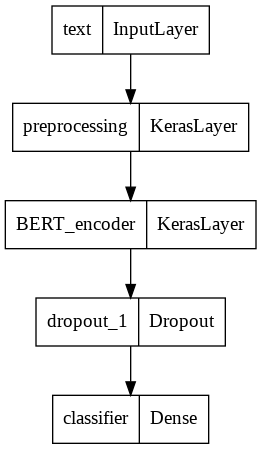

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


In [ ]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [ ]:
num_classes = 12
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 10

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(X_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (X_test, y_test),
                      callbacks = [earlystop_callback],
                      batch_size = 32)


Epoch 1/10
3750/3750 [==============================] - 260s 69ms/step - loss: 0.6195 - categorical_accuracy: 0.7647 - balanced_recall: 0.7063 - balanced_precision: 0.8109 - balanced_f1_score: 0.7522 - val_loss: 0.5142 - val_categorical_accuracy: 0.8124 - val_balanced_recall: 0.7652 - val_balanced_precision: 0.8503 - val_balanced_f1_score: 0.8044
Epoch 2/10
3750/3750 [==============================] - 255s 68ms/step - loss: 0.5708 - categorical_accuracy: 0.7868 - balanced_recall: 0.7405 - balanced_precision: 0.8273 - balanced_f1_score: 0.7804 - val_loss: 0.5043 - val_categorical_accuracy: 0.8163 - val_balanced_recall: 0.7656 - val_balanced_precision: 0.8512 - val_balanced_f1_score: 0.8048
Epoch 3/10
3750/3750 [==============================] - 252s 67ms/step - loss: 0.5572 - categorical_accuracy: 0.7918 - balanced_recall: 0.7468 - balanced_precision: 0.8305 - balanced_f1_score: 0.7854 - val_loss: 0.4805 - val_categorical_accuracy: 0.8288 - val_balanced_recall: 0.7769 - val_balanced_pre

In [ ]:
model.save("/content/drive/MyDrive/Ag_news_dataset/bert_text_classifier_NYT")

In [ ]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(X_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (X_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
350/350 [==============================] - 45s 98ms/step - loss: 2.8556 - categorical_accuracy: 0.2226 - balanced_recall: 0.0292 - balanced_precision: 0.0332 - balanced_f1_score: 0.0307 - val_loss: 2.2587 - val_categorical_accuracy: 0.3821 - val_balanced_recall: 0.0733 - val_balanced_precision: 0.0813 - val_balanced_f1_score: 0.0766
Epoch 2/20
350/350 [==============================] - 30s 87ms/step - loss: 2.3253 - categorical_accuracy: 0.3490 - balanced_recall: 0.0799 - balanced_precision: 0.0931 - balanced_f1_score: 0.0854 - val_loss: 2.0265 - val_categorical_accuracy: 0.4325 - val_balanced_recall: 0.1024 - val_balanced_precision: 0.1180 - val_balanced_f1_score: 0.1090
Epoch 3/20
350/350 [==============================] - 31s 88ms/step - loss: 2.1949 - categorical_accuracy: 0.3757 - balanced_recall: 0.1006 - balanced_precision: 0.1172 - balanced_f1_score: 0.1076 - val_loss: 1.9715 - val_categorical_accuracy: 0.4355 - val_balanced_recall: 0.1191 - val_balanced_precision: 0

In [ ]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(X_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (X_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
350/350 [==============================] - 221s 594ms/step - loss: 2.9092 - categorical_accuracy: 0.2169 - balanced_recall: 0.0239 - balanced_precision: 0.0283 - balanced_f1_score: 0.0255 - val_loss: 2.4361 - val_categorical_accuracy: 0.3330 - val_balanced_recall: 0.0642 - val_balanced_precision: 0.0741 - val_balanced_f1_score: 0.0682
Epoch 2/20
350/350 [==============================] - 204s 582ms/step - loss: 2.2968 - categorical_accuracy: 0.3751 - balanced_recall: 0.0820 - balanced_precision: 0.1045 - balanced_f1_score: 0.0911 - val_loss: 2.0562 - val_categorical_accuracy: 0.4577 - val_balanced_recall: 0.1031 - val_balanced_precision: 0.1318 - val_balanced_f1_score: 0.1149
Epoch 3/20
350/350 [==============================] - 204s 582ms/step - loss: 2.0811 - categorical_accuracy: 0.4210 - balanced_recall: 0.1233 - balanced_precision: 0.1547 - balanced_f1_score: 0.1364 - val_loss: 1.9710 - val_categorical_accuracy: 0.4411 - val_balanced_recall: 0.1373 - val_balanced_precis

In [ ]:
n_epochs = 5

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(X_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (X_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/5
3049/3049 [==============================] - 439s 143ms/step - loss: 1.1225 - categorical_accuracy: 0.6408 - balanced_recall: 0.3702 - balanced_precision: 0.4679 - balanced_f1_score: 0.4112 - val_loss: 1.0096 - val_categorical_accuracy: 0.6750 - val_balanced_recall: 0.4059 - val_balanced_precision: 0.4967 - val_balanced_f1_score: 0.4450
Epoch 2/5
3049/3049 [==============================] - 437s 143ms/step - loss: 1.0816 - categorical_accuracy: 0.6536 - balanced_recall: 0.3863 - balanced_precision: 0.4835 - balanced_f1_score: 0.4274 - val_loss: 0.9880 - val_categorical_accuracy: 0.6838 - val_balanced_recall: 0.4140 - val_balanced_precision: 0.5037 - val_balanced_f1_score: 0.4526
Epoch 3/5
3049/3049 [==============================] - 439s 144ms/step - loss: 1.0574 - categorical_accuracy: 0.6599 - balanced_recall: 0.3953 - balanced_precision: 0.4924 - balanced_f1_score: 0.4366 - val_loss: 0.9749 - val_categorical_accuracy: 0.6881 - val_balanced_recall: 0.4158 - val_balanced_pre

In [ ]:
model.save("/content/drive/MyDrive/nlp/bert_classifier_breaking_news")